In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import math
import random
from typing import List, Tuple, Optional
%matplotlib inline

# For interactive plots in Jupyter
%config InlineBackend.close_figures = False
plt.ion()

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.children = []
        self.cost = 0.0

class Obstacle:
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        
    def contains(self, point):
        x, y = point
        return (self.x <= x <= self.x + self.width and 
                self.y <= y <= self.y + self.height)
    
    def plot(self, ax):
        rect = plt.Rectangle((self.x, self.y), self.width, self.height, 
                           facecolor='gray', alpha=0.7)
        ax.add_patch(rect)


In [2]:
class InformedRRTStar():
    def __init__(self, max_iters=1000):
        self.max_iters = int(max_iters)
        self.step_size = 0.5
        self.goal_threshold = 0.5
        self.goal_bias = 0.1
        self.search_space = (-2, -2, 12, 12)  # x_min, y_min, x_max, y_max
        self.rewire_radius = 1.5  # Radius for rewiring in RRT*
        
        plt.close('all')
        self.fig, self.ax = plt.subplots(figsize=(10, 10))

        self.nodes = []
        self.obstacles = []
        self.path = []
        self.best_path_cost = float('inf')
        self.best_goal_node = None
        
        # Ellipse parameters for informed sampling
        self.c_min = 0
        self.c_best = float('inf')
        self.x_center = np.zeros(2)
        self.C = np.eye(2)
        
        self.x_min = self.search_space[0]
        self.x_max = self.search_space[2]
        self.y_min = self.search_space[1]
        self.y_max = self.search_space[3]

    def plot_tree(self, start_node, goal_node, final_path=False):
        """Visualize the RRT* tree"""
        self.ax.clear()
        
        # Set up the plot
        self.ax.set_xlim(self.search_space[0], self.search_space[2])
        self.ax.set_ylim(self.search_space[1], self.search_space[3])
        self.ax.set_aspect('equal')
        self.ax.grid(True)
        
        # Plot start and goal
        self.ax.plot(start_node.x, start_node.y, 'go', markersize=10, label='Start')
        self.ax.plot(goal_node.x, goal_node.y, 'ro', markersize=10, label='Goal')
        
        # Plot obstacles
        for obstacle in self.obstacles:
            obstacle.plot(self.ax)
        
        # Plot the tree
        for node in self.nodes:
            if node.parent is not None:
                self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], 'b-', alpha=0.3)
        
        # Plot the final path if requested
        if final_path and self.path:
            path_x = [p[0] for p in self.path]
            path_y = [p[1] for p in self.path]
            self.ax.plot(path_x, path_y, 'g-', linewidth=3, label='Optimal Path')
            
        # Plot informed sampling ellipse if available
        if self.c_best < float('inf') and final_path:
            self.plot_ellipse(start_node, goal_node)
        
        plt.title(f"Informed RRT* Path Planning - Best Cost: {self.best_path_cost:.2f}")
        plt.legend()
        plt.draw()
        plt.pause(0.01)
    
    def plot_ellipse(self, start_node, goal_node):
        """Plot the informed sampling ellipse"""
        if self.c_best <= self.c_min:
            return
            
        # Calculate ellipse parameters
        a = self.c_best / 2
        c = self.euclid_distance(start_node.x, goal_node.x, start_node.y, goal_node.y) / 2
        b = math.sqrt(a**2 - c**2)
        
        # Ellipse rotation angle
        theta = math.atan2(goal_node.y - start_node.y, goal_node.x - start_node.x)
        
        # Generate ellipse points
        t = np.linspace(0, 2 * np.pi, 100)
        x_ellipse = a * np.cos(t) * np.cos(theta) - b * np.sin(t) * np.sin(theta) + self.x_center[0]
        y_ellipse = a * np.cos(t) * np.sin(theta) + b * np.sin(t) * np.cos(theta) + self.x_center[1]
        
        self.ax.plot(x_ellipse, y_ellipse, 'r--', alpha=0.5, label='Informed Sampling Region')

    def build_path(self, node):
        """Build the path from start to goal"""
        path = []
        while node is not None:
            path.append((node.x, node.y))
            node = node.parent
        return path[::-1]  # Reverse to get start-to-goal order

    def add_obstacle(self, obstacle):
        """Add obstacle to the environment"""
        self.obstacles.append(obstacle)
        
    def collision_free(self, from_node_x, from_node_y, to_node_x, to_node_y):
        """Check if path between nodes is collision-free"""
        for obstacle in self.obstacles:
            if self.line_intersects_obstacle(from_node_x, from_node_y, to_node_x, to_node_y, obstacle):
                return False
        return True
    
    def line_intersects_obstacle(self, from_node_x, from_node_y, to_node_x, to_node_y, obstacle):
        """Check if line segment intersects obstacle"""
        steps = max(20, int(self.euclid_distance(from_node_x, to_node_x, from_node_y, to_node_y) / 0.1))
        for i in range(steps + 1):
            t = i / steps
            x = from_node_x + t * (to_node_x - from_node_x)
            y = from_node_y + t * (to_node_y - from_node_y)
            if obstacle.contains((x, y)):
                return True
        return False
        
    def euclid_distance(self, x1, x2, y1, y2):
        return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    def sample(self, goal_node, start_node):
        """Sample point - uses informed sampling once a solution is found"""
        if self.c_best < float('inf'):
            # Informed sampling: sample within the ellipse
            return self.informed_sample(goal_node, start_node)
        else:
            # Standard sampling before first solution
            if random.random() < self.goal_bias:
                return goal_node.x, goal_node.y
            x = random.uniform(self.x_min, self.x_max)
            y = random.uniform(self.y_min, self.y_max)
            return (x, y)

    def informed_sample(self, goal_node, start_node):
        """Sample within the informed ellipse"""
        # Ellipse parameters
        c_min = self.euclid_distance(start_node.x, goal_node.x, start_node.y, goal_node.y)
        a = self.c_best / 2
        c = c_min / 2
        
        if a < c:  # No ellipse exists
            return goal_node.x, goal_node.y
            
        b = math.sqrt(a**2 - c**2)
        
        # Ellipse center
        x_center = np.array([(start_node.x + goal_node.x) / 2, 
                           (start_node.y + goal_node.y) / 2])
        
        # Rotation angle
        theta = math.atan2(goal_node.y - start_node.y, goal_node.x - start_node.x)
        
        # Sample in unit circle
        while True:
            r = math.sqrt(random.uniform(0, 1))
            angle = random.uniform(0, 2 * math.pi)
            
            x_unit = r * math.cos(angle)
            y_unit = r * math.sin(angle)
            
            # Transform to ellipse
            x_ellipse = a * x_unit * math.cos(theta) - b * y_unit * math.sin(theta) + x_center[0]
            y_ellipse = a * x_unit * math.sin(theta) + b * y_unit * math.cos(theta) + x_center[1]
            
            # Check if within bounds
            if (self.x_min <= x_ellipse <= self.x_max and 
                self.y_min <= y_ellipse <= self.y_max):
                return (x_ellipse, y_ellipse)

    def nearest_neighbor(self, point: tuple):
        """Find the nearest node to the given point"""
        x, y = point
        min_distance = float('inf')
        the_node = None
        for node in self.nodes:
            distance = self.euclid_distance(x, node.x, y, node.y)
            if distance < min_distance:
                min_distance = distance
                the_node = node
        return the_node

    def near_nodes(self, point, radius):
        """Find all nodes within a given radius of the point"""
        x, y = point
        near_nodes = []
        for node in self.nodes:
            distance = self.euclid_distance(x, node.x, y, node.y)
            if distance <= radius:
                near_nodes.append(node)
        return near_nodes

    def steer(self, from_x, from_y, to_x, to_y):
        """Steer towards the target point"""
        dx = to_x - from_x
        dy = to_y - from_y
        distance = math.sqrt(dx**2 + dy**2)
        
        if distance <= self.step_size:
            return (to_x, to_y)
        else:
            theta = math.atan2(dy, dx)
            new_x = from_x + self.step_size * math.cos(theta)
            new_y = from_y + self.step_size * math.sin(theta)
            return (new_x, new_y)

    def choose_parent(self, new_node, near_nodes):
        """Choose the best parent for the new node"""
        best_node = None
        best_cost = float('inf')
        
        for node in near_nodes:
            if self.collision_free(node.x, node.y, new_node.x, new_node.y):
                cost = node.cost + self.euclid_distance(node.x, new_node.x, node.y, new_node.y)
                if cost < best_cost:
                    best_cost = cost
                    best_node = node
        
        return best_node, best_cost

    def rewire(self, new_node, near_nodes):
        """Rewire the tree in the neighborhood of the new node"""
        for node in near_nodes:
            if node == new_node.parent:
                continue
                
            if self.collision_free(new_node.x, new_node.y, node.x, node.y):
                new_cost = new_node.cost + self.euclid_distance(new_node.x, node.x, new_node.y, node.y)
                if new_cost < node.cost:
                    # Remove from old parent's children
                    if node.parent:
                        node.parent.children.remove(node)
                    
                    # Update parent and cost
                    node.parent = new_node
                    node.cost = new_cost
                    new_node.children.append(node)
                    
                    # Propagate cost improvement to descendants
                    self.propagate_cost_to_descendants(node)

    def propagate_cost_to_descendants(self, node):
        """Update costs for all descendants after rewiring"""
        for child in node.children:
            old_cost = child.cost
            child.cost = node.cost + self.euclid_distance(node.x, child.x, node.y, child.y)
            cost_diff = child.cost - old_cost
            self.propagate_cost_to_descendants(child)

    def update_informed_set(self, start_node, goal_node):
        """Update the informed sampling parameters"""
        self.c_min = self.euclid_distance(start_node.x, goal_node.x, start_node.y, goal_node.y)
        self.x_center = np.array([(start_node.x + goal_node.x) / 2, 
                                (start_node.y + goal_node.y) / 2])

    def run_informed_rrt_star(self, start_position: list, goal_position: list):
        """Run the Informed RRT* algorithm"""
        start_node = Node(start_position[0], start_position[1])
        goal_node = Node(goal_position[0], goal_position[1])
        self.nodes.append(start_node)
        
        self.update_informed_set(start_node, goal_node)
        
        for i in range(0, self.max_iters):
            if i % 50 == 0:
                self.plot_tree(start_node, goal_node)
                
            # Sample new point
            point = self.sample(goal_node, start_node)
            x_point, y_point = point
            
            # Find nearest node and steer
            nearest_node = self.nearest_neighbor(point)
            new_point = self.steer(nearest_node.x, nearest_node.y, x_point, y_point)
            
            # Check collision
            if not self.collision_free(nearest_node.x, nearest_node.y, new_point[0], new_point[1]):
                continue
                
            # Create new node
            new_node = Node(new_point[0], new_point[1])
            
            # Find near nodes and choose best parent
            near_nodes = self.near_nodes(new_point, self.rewire_radius)
            best_parent, best_cost = self.choose_parent(new_node, near_nodes)
            
            if best_parent is None:
                continue
                
            # Set parent and cost
            new_node.parent = best_parent
            new_node.cost = best_cost
            best_parent.children.append(new_node)
            
            # Add to tree and rewire
            self.nodes.append(new_node)
            self.rewire(new_node, near_nodes)
            
            # Check if goal is reached
            distance_to_goal = self.euclid_distance(new_node.x, goal_node.x, new_node.y, goal_node.y)
            if distance_to_goal < self.goal_threshold:
                # Create goal node and connect it
                goal_node.parent = new_node
                goal_node.cost = new_node.cost + distance_to_goal
                
                if goal_node.cost < self.best_path_cost:
                    self.best_path_cost = goal_node.cost
                    self.best_goal_node = goal_node
                    self.path = self.build_path(goal_node)
                    self.c_best = goal_node.cost
                    
                    print(f"New best path found at iteration {i} with cost: {self.best_path_cost:.2f}")
                    self.plot_tree(start_node, goal_node, final_path=True)

        # Final plot with best path
        if self.best_goal_node:
            self.path = self.build_path(self.best_goal_node)
            self.plot_tree(start_node, goal_node, final_path=True)
            return True, i
        else:
            return False, self.max_iters


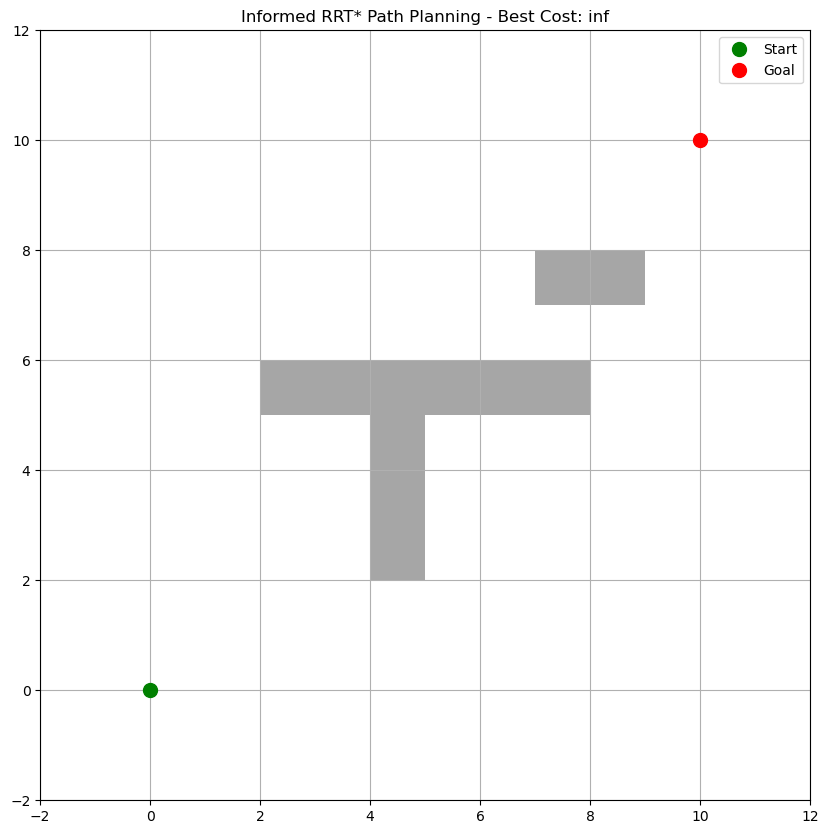

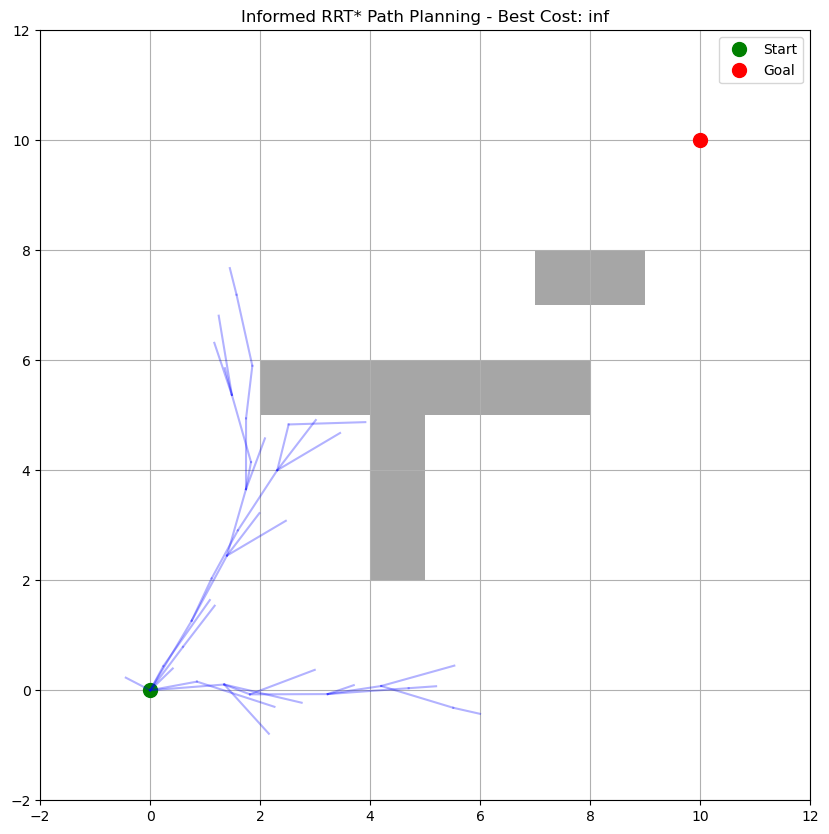

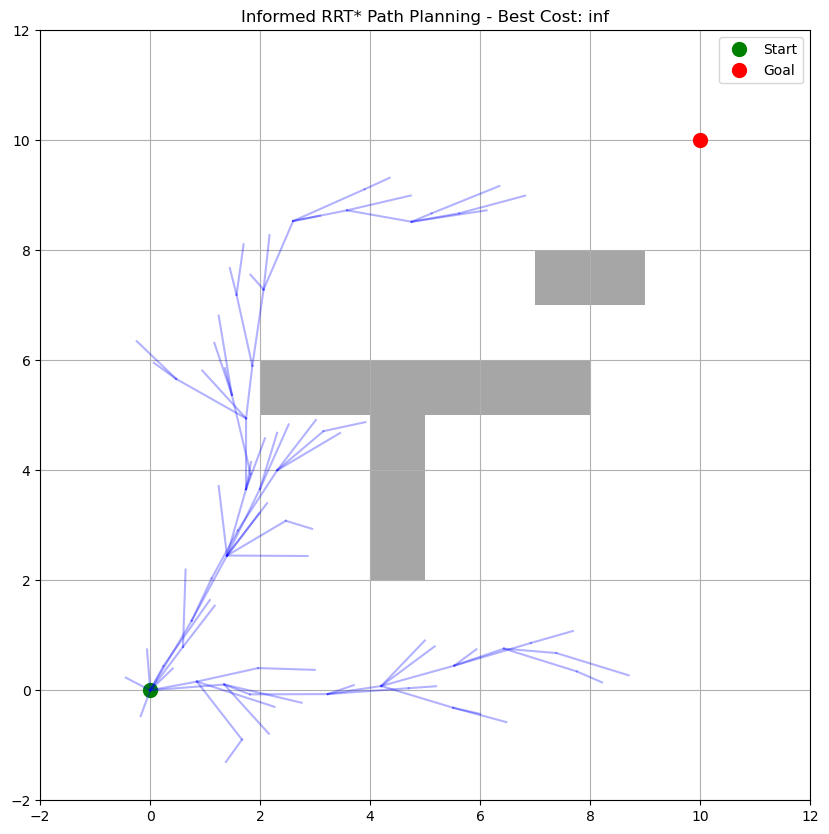

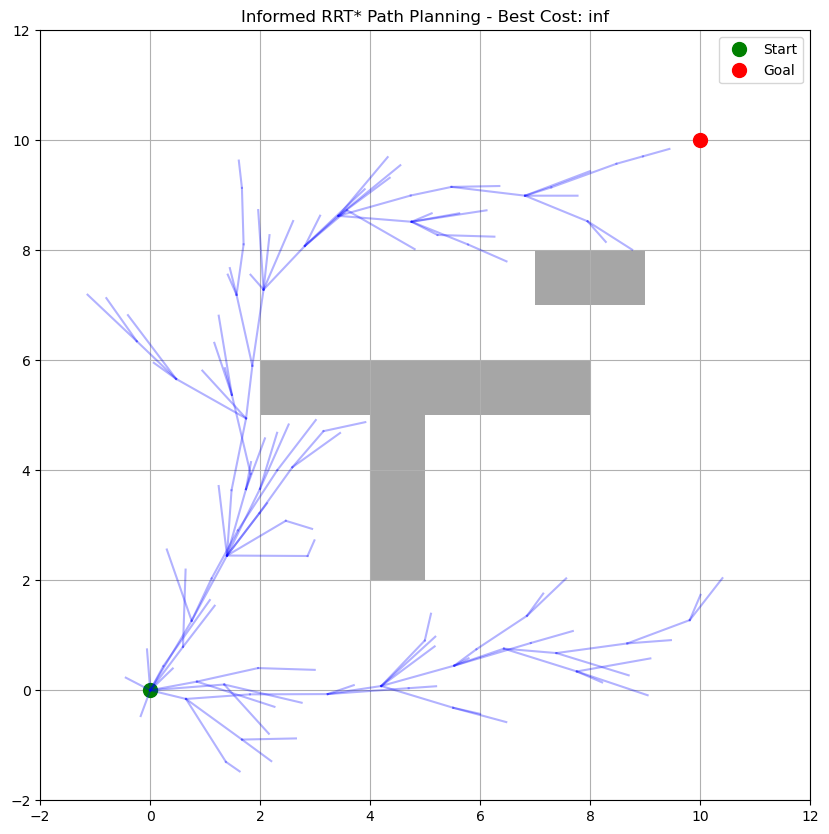

New best path found at iteration 159 with cost: 16.43


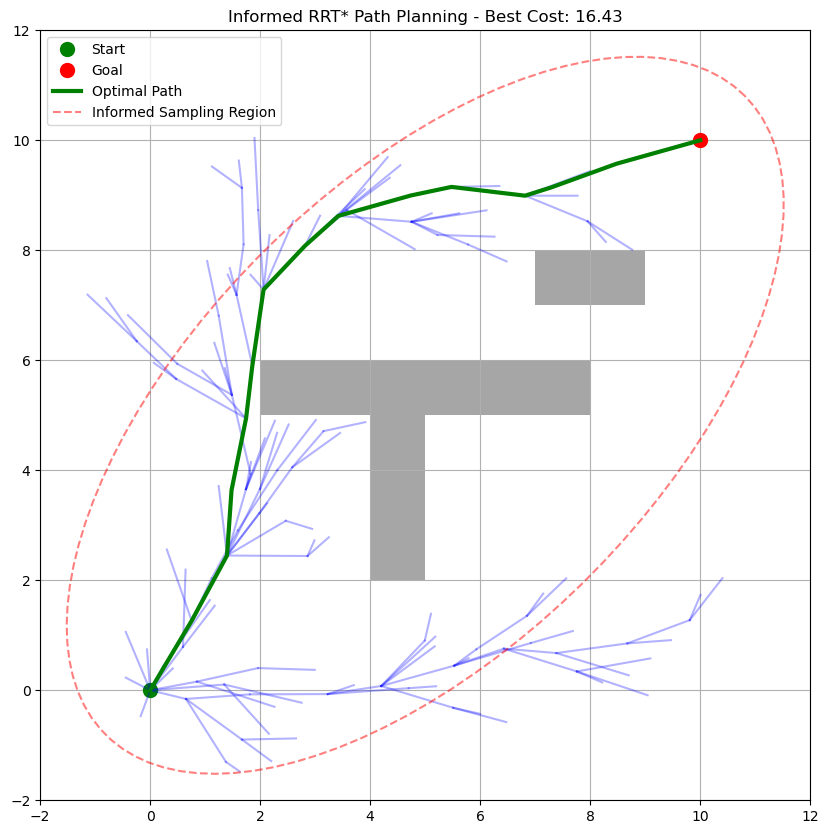

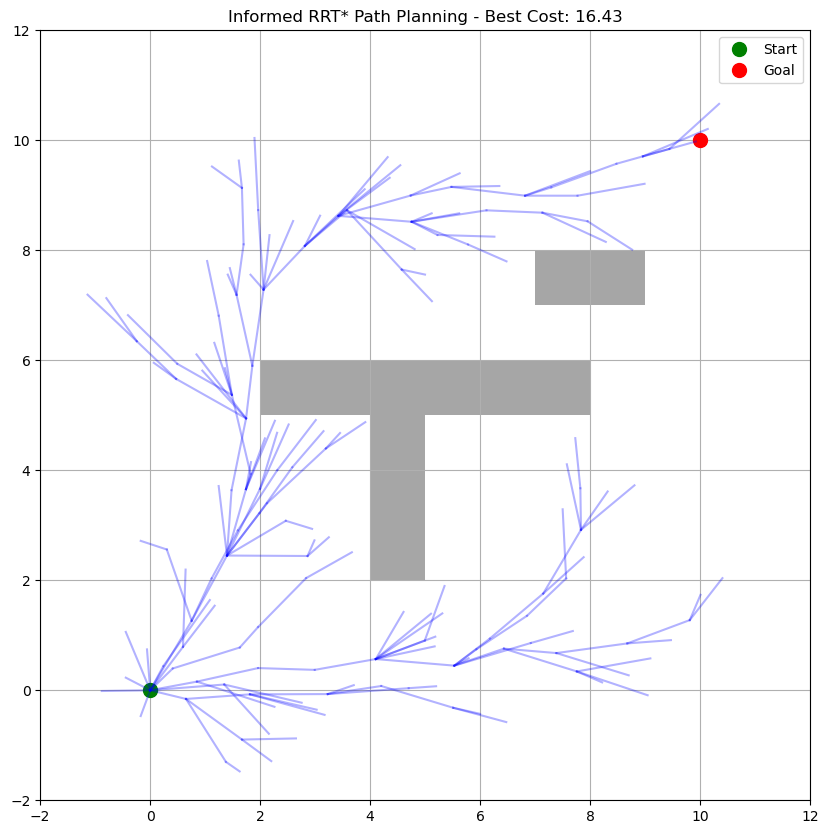

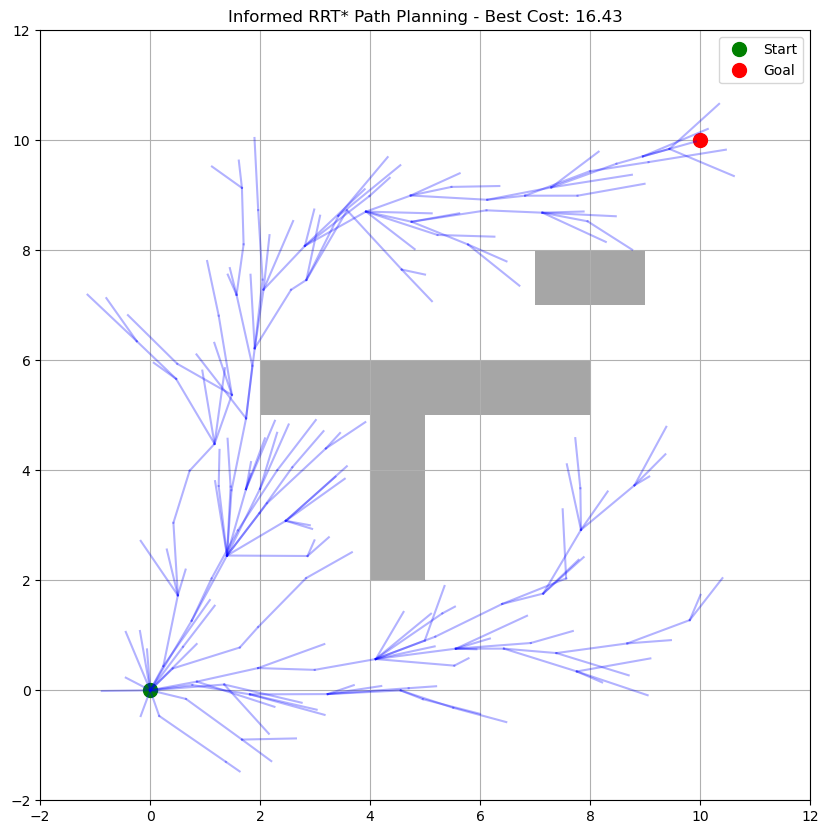

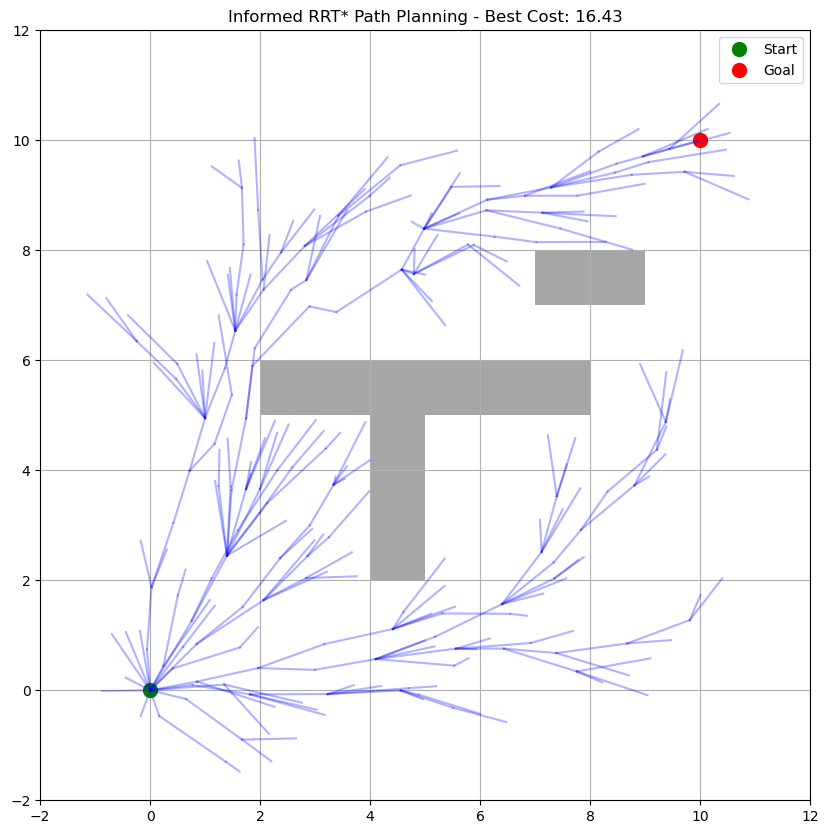

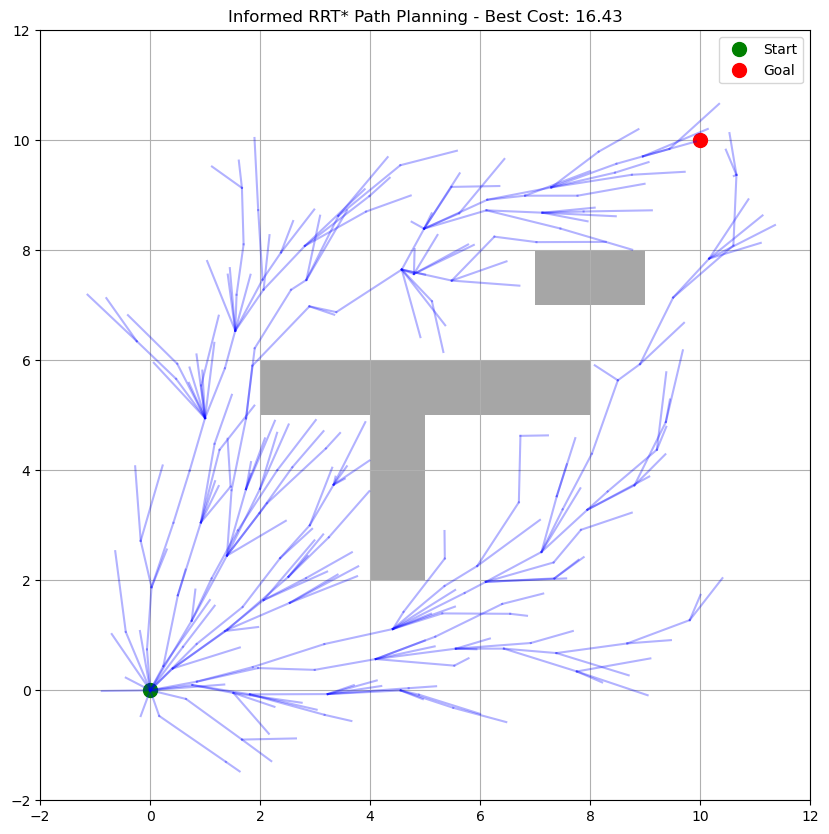

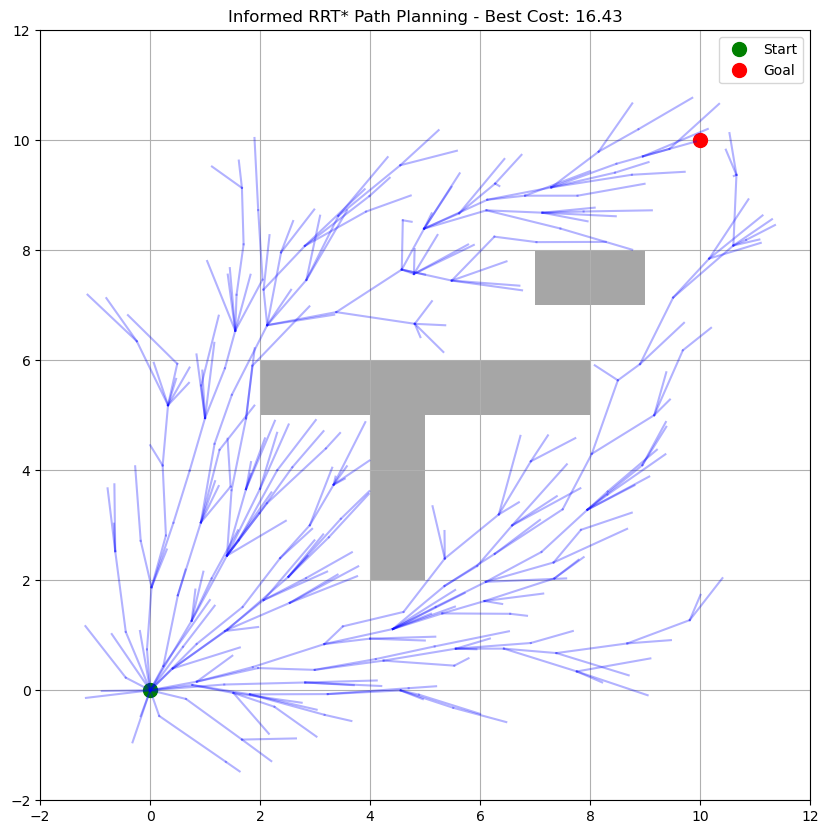

New best path found at iteration 422 with cost: 15.72


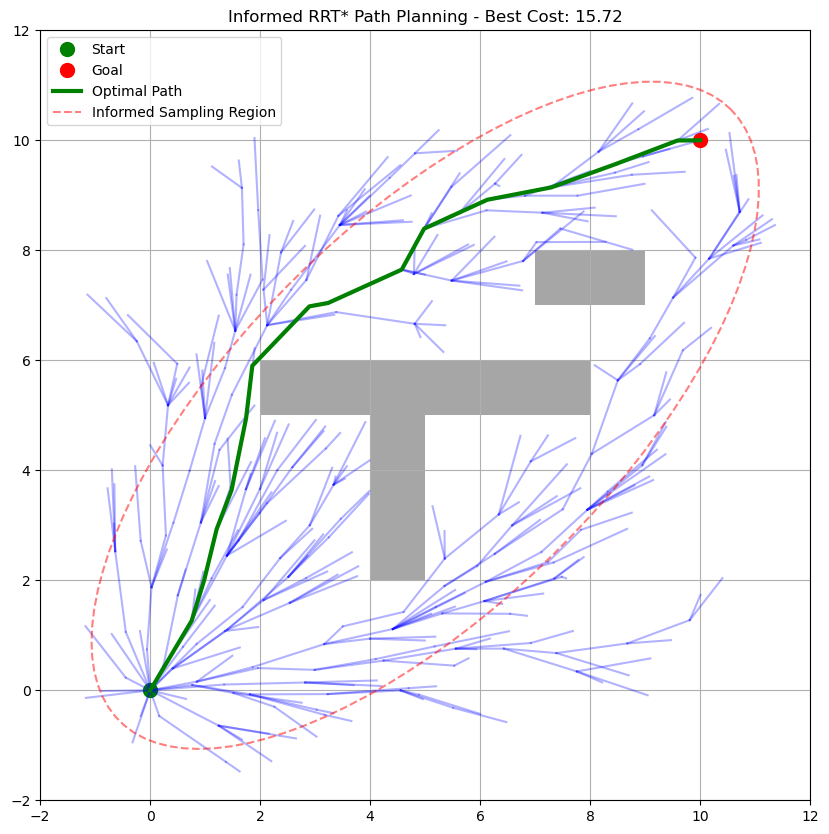

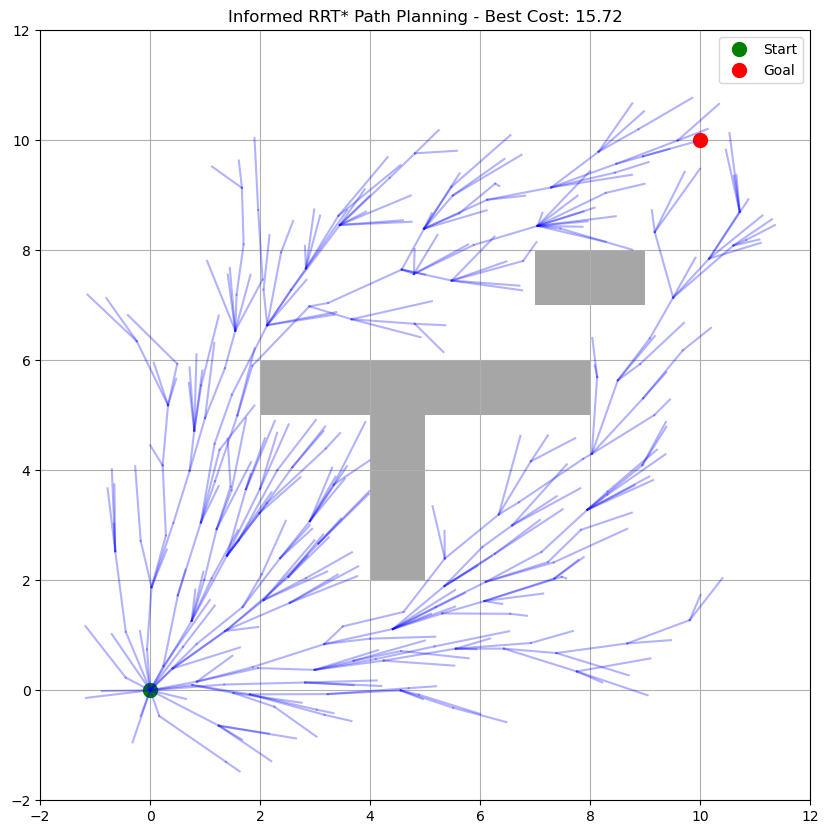

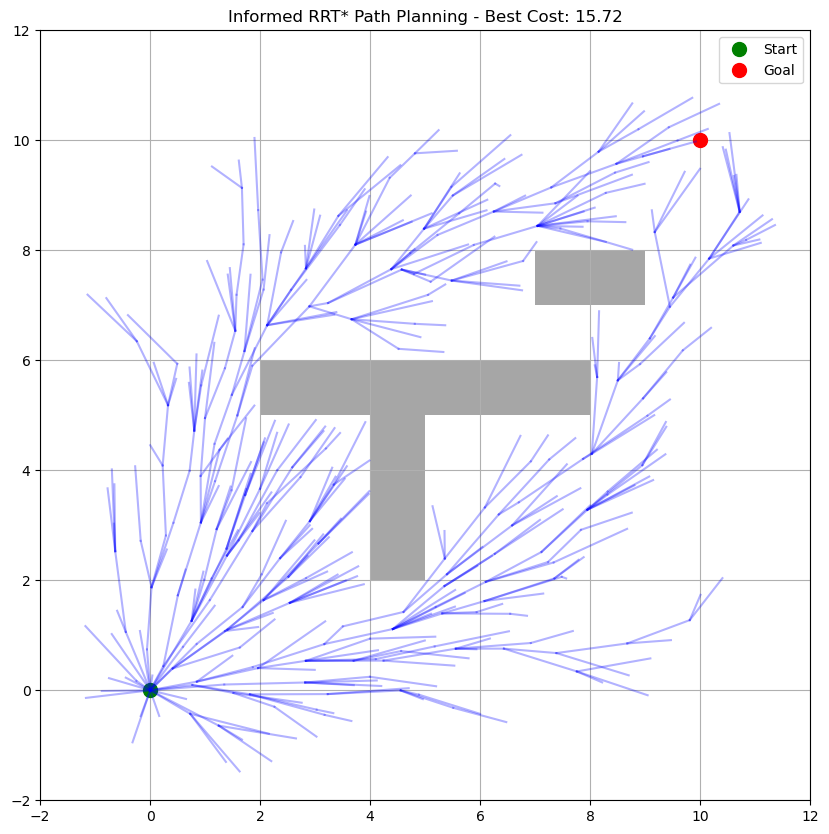

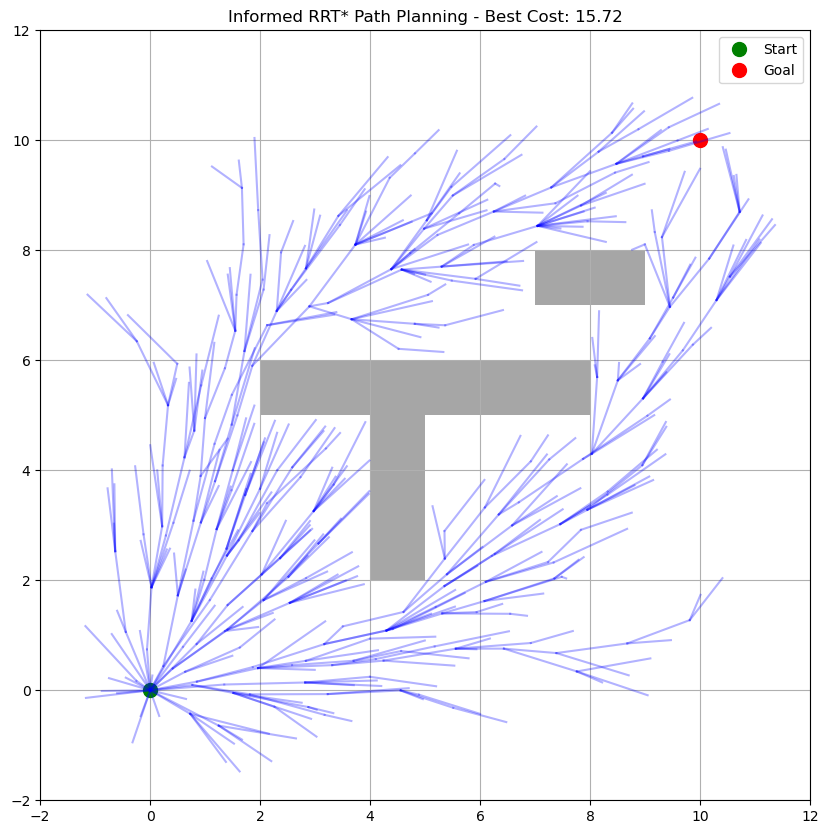

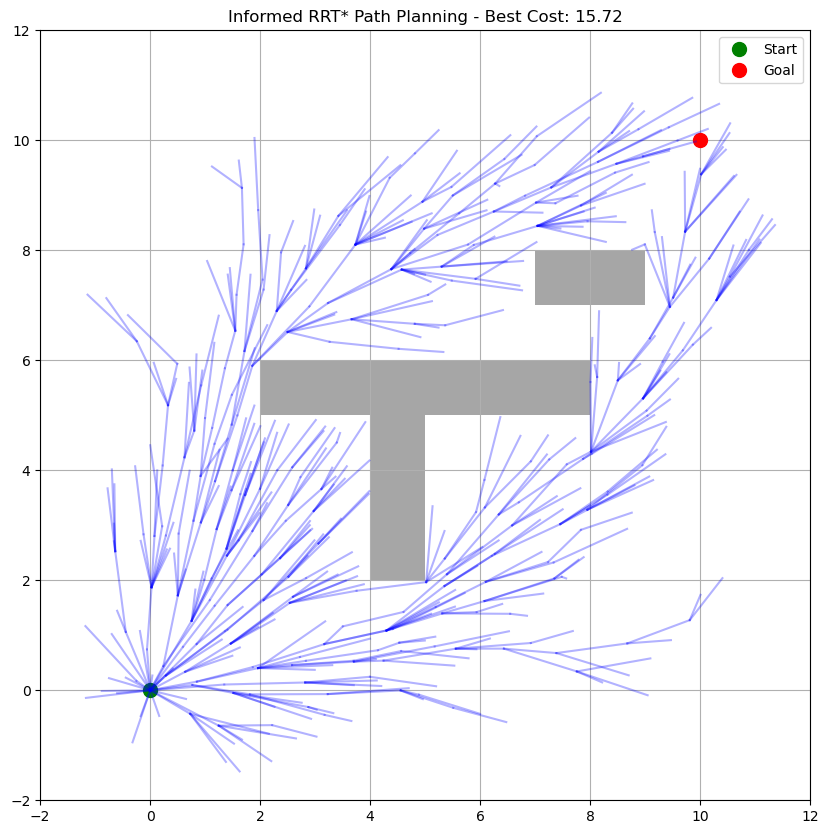

New best path found at iteration 619 with cost: 15.38


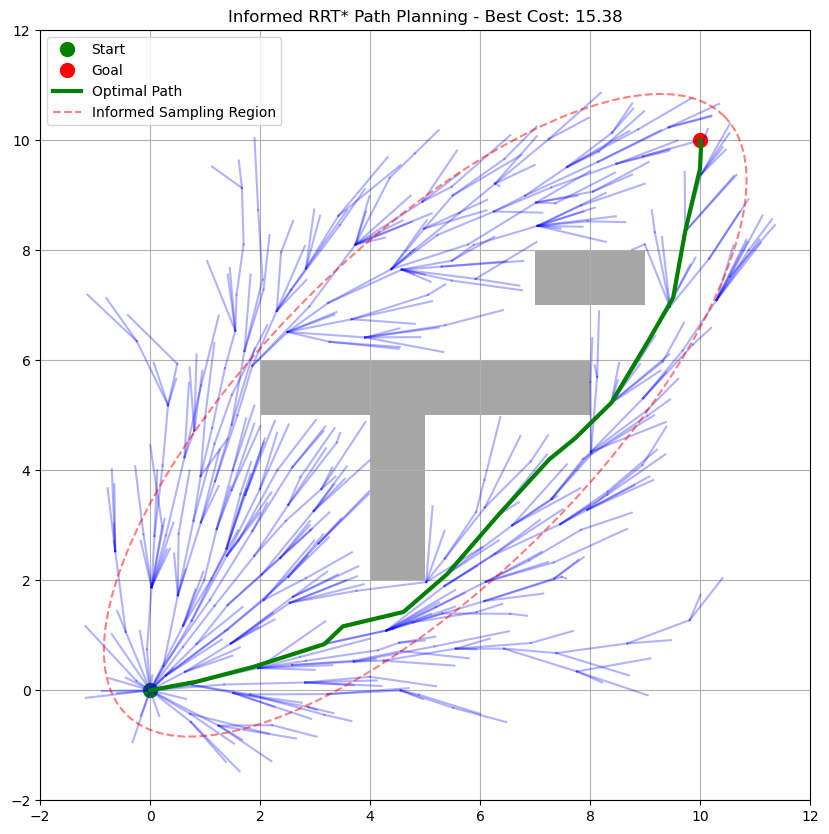

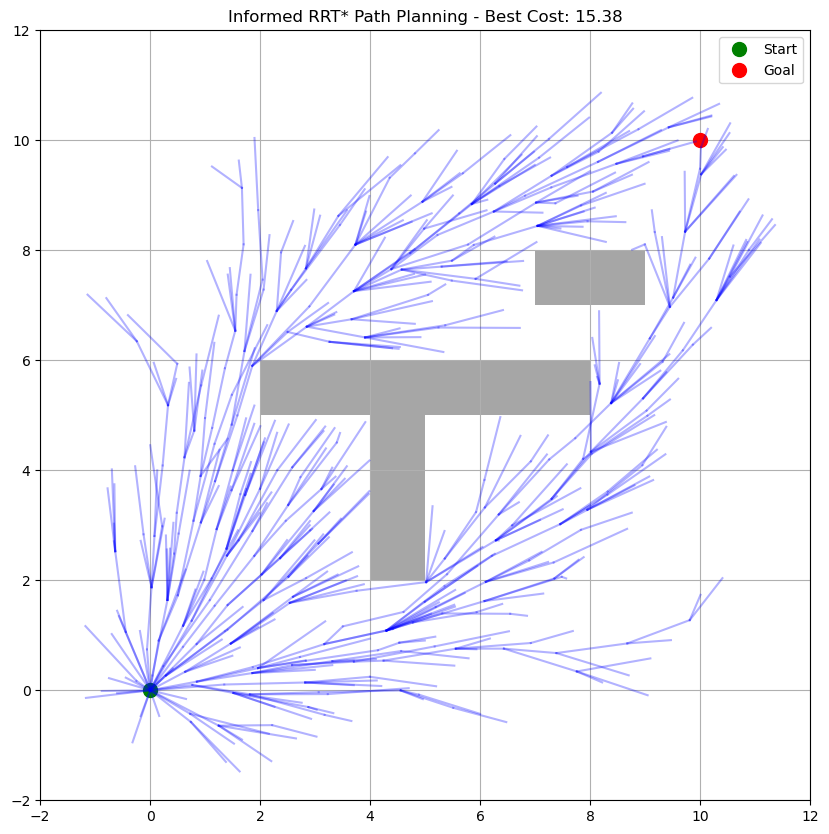

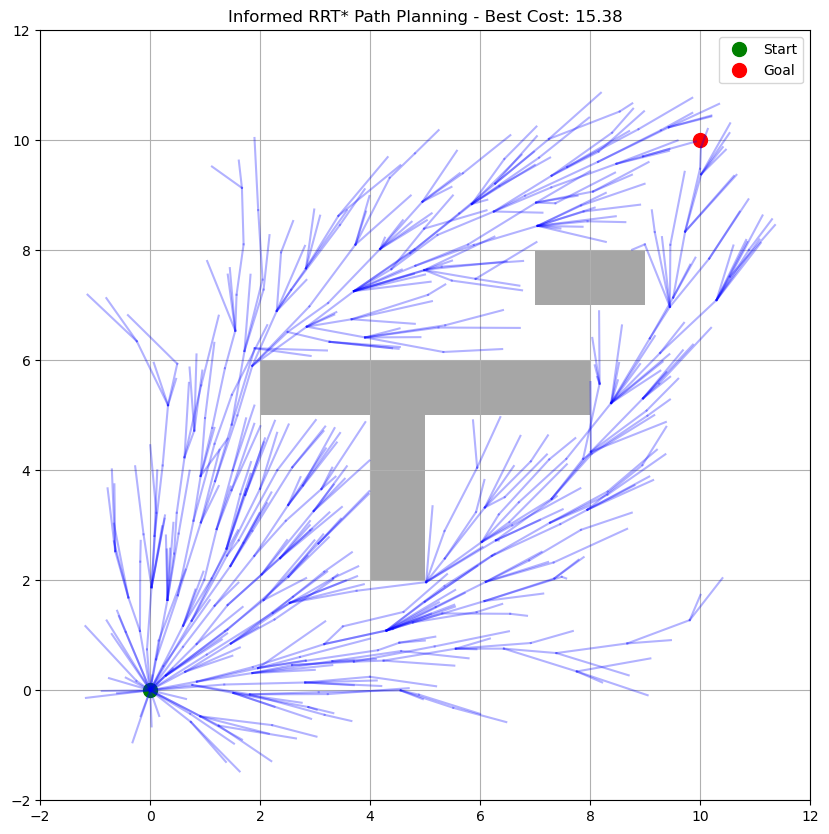

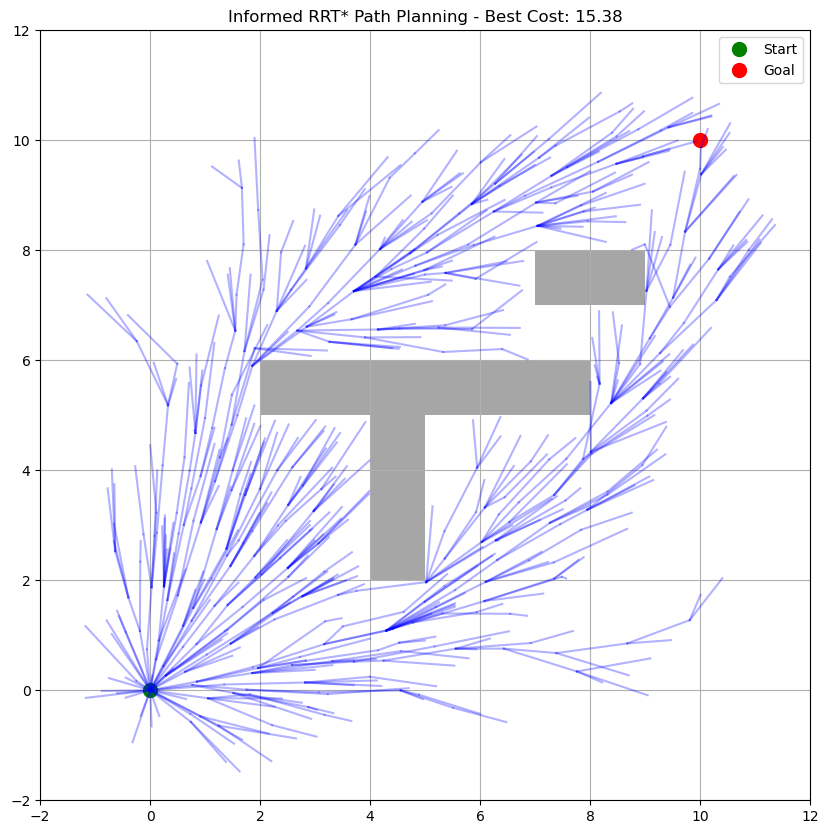

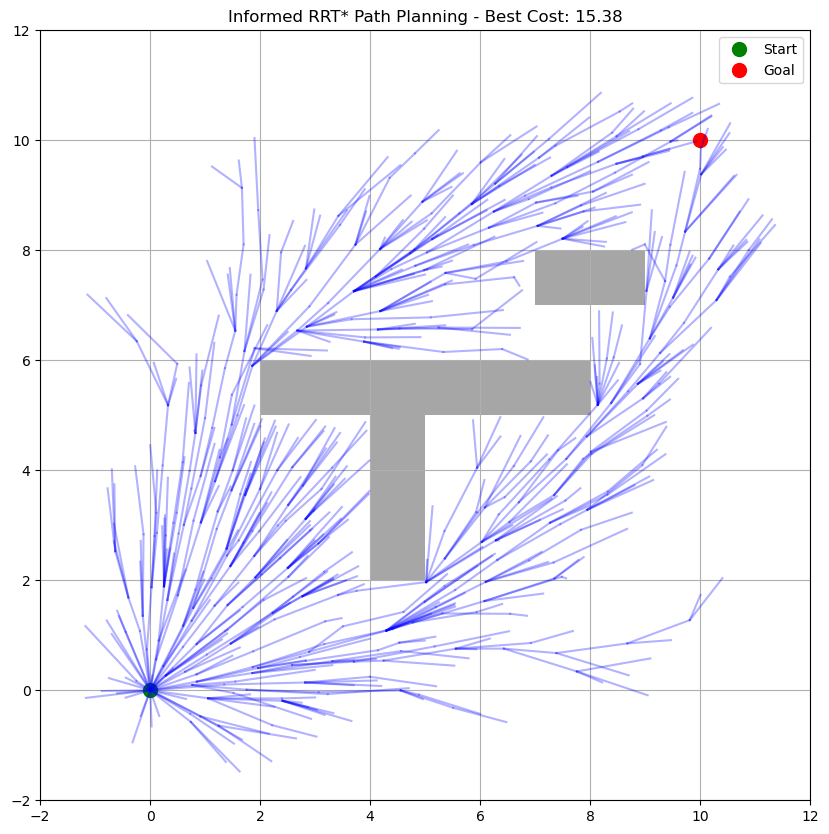

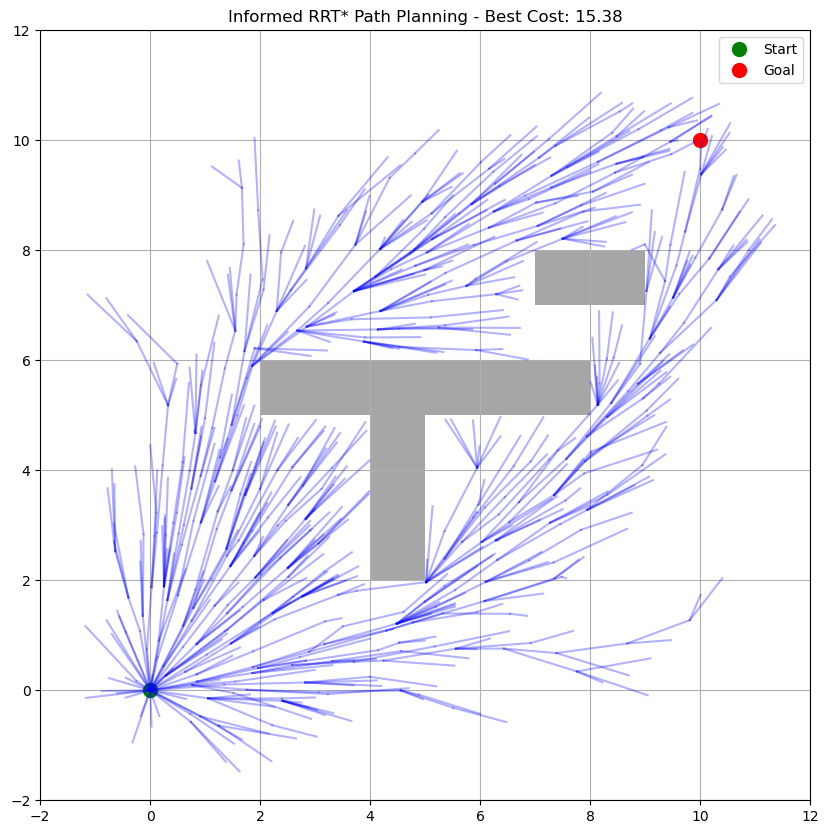

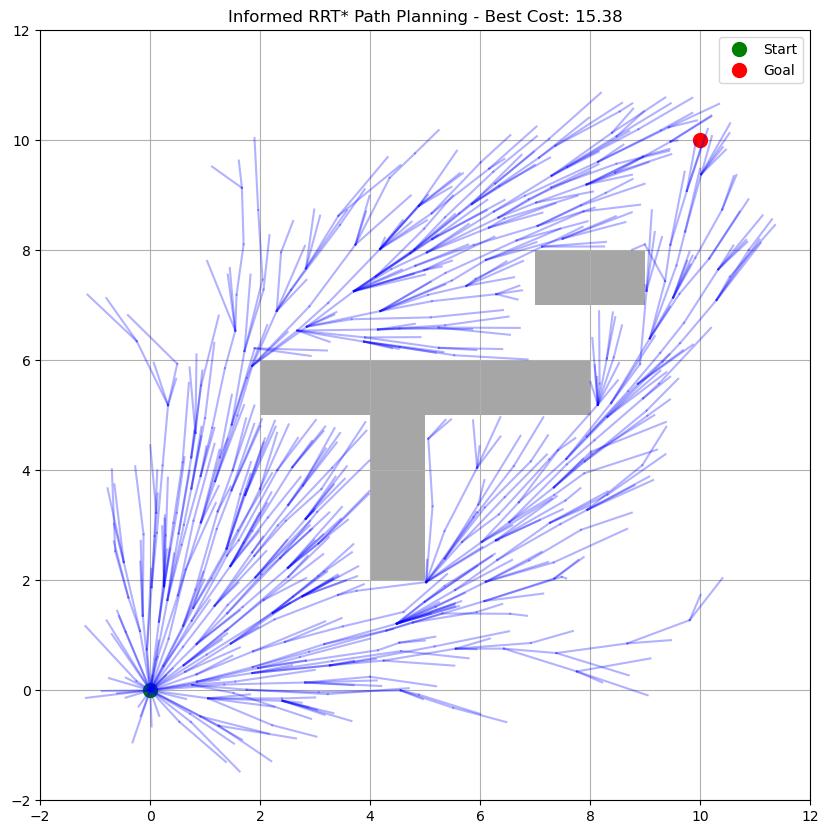

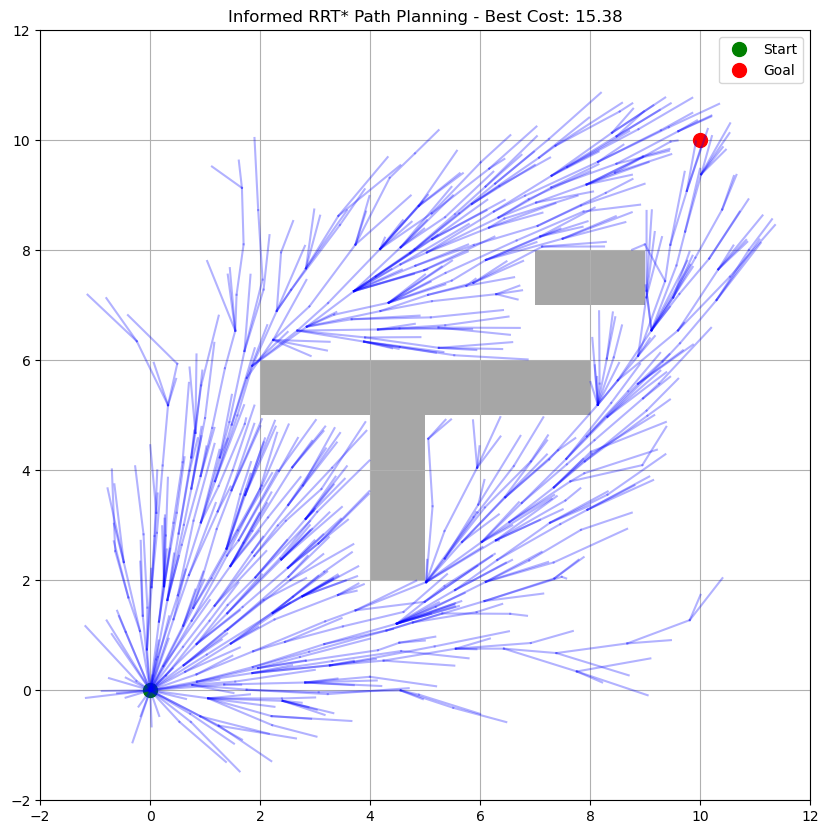

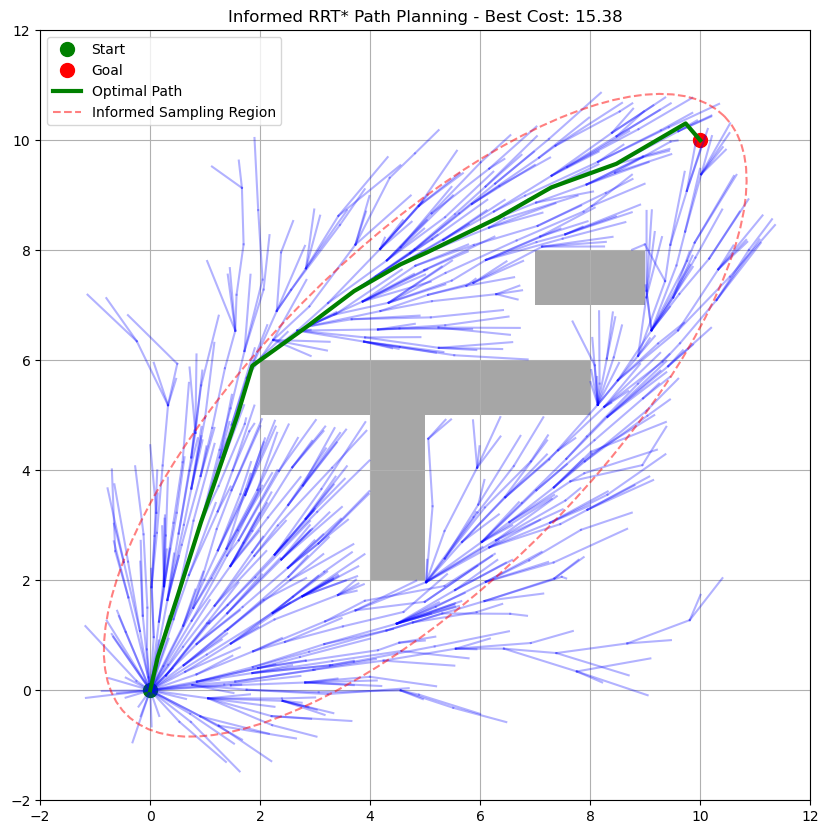

Path found in 999 iterations!
Best path cost: 15.38
Path: [(0, 0), (0.1378966040637417, 0.6035851693252141), (0.5023628435006025, 1.7272434776398091), (0.921560207741639, 3.052498281178082), (1.1791620298802812, 3.801820119998615), (1.5848880818111475, 4.998331348799592), (1.8564109361590524, 5.900120795412791), (2.847330655435718, 6.611302388318633), (3.705927049056096, 7.2578187462018455), (4.550458368634916, 7.74362986850206), (5.031384151625028, 7.9609842006954885), (6.332560591011507, 8.595000695960186), (7.292401978275533, 9.143473539565548), (8.477049548330502, 9.572996547239555), (9.735209969871837, 10.306211161332122), (10, 10)]
Path Length: 16


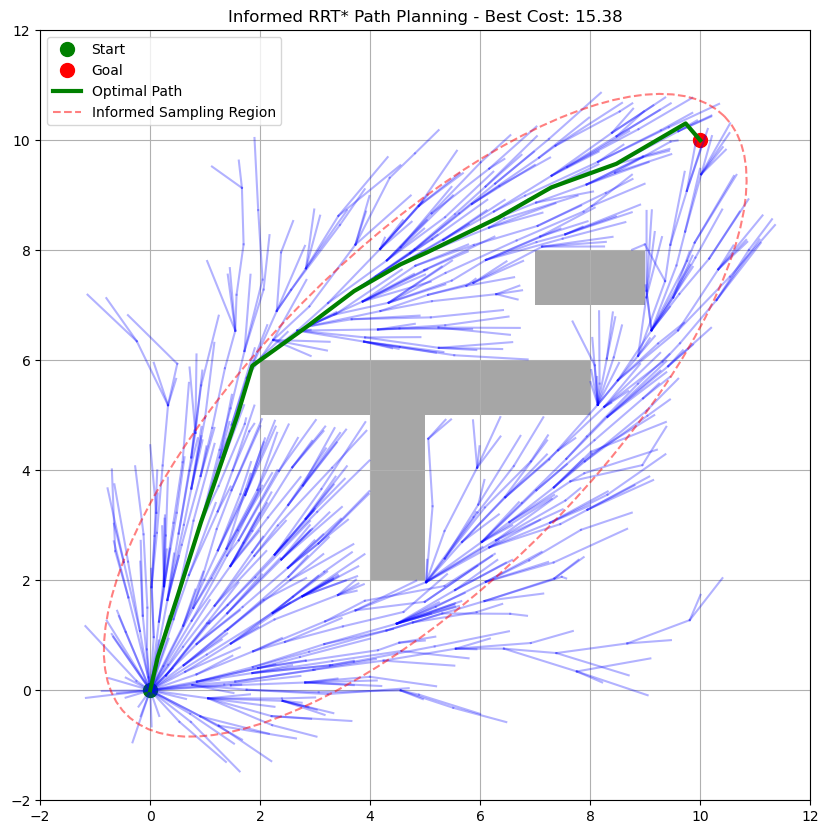

In [3]:

# Example usage
if __name__ == "__main__":
    rrt_star = InformedRRTStar(max_iters=1000)
    
    # Add obstacles
    rrt_star.add_obstacle(Obstacle(4, 2, 1, 3))
    rrt_star.add_obstacle(Obstacle(2, 5, 6, 1))
    rrt_star.add_obstacle(Obstacle(7, 7, 2, 1))
    
    success, iterations = rrt_star.run_informed_rrt_star([0, 0], [10, 10])
    
    if success:
        print(f"Path found in {iterations} iterations!")
        print(f"Best path cost: {rrt_star.best_path_cost:.2f}")
        print("Path:", rrt_star.path)
        print("Path Length:", len(rrt_star.path))
    else:
        print(f"Failed to find path after {iterations} iterations.")
    
    plt.show()